# House Prices - Advanced Regression Techniques
This is the notebook that will guiding you to the journey of making prediction on House Prices datasets by using Machine learning algorithms with the approach of feature engineering. 
For this example, we will use some important libraries of Machine Learning that will help us to predict our datasets. <br>
House prices datasets is published on Kaggle which is the Ames Housing dataset and it is used in data science education. The datasets consists 2 important datas such as `train.csv` and `test.csv`. The <strong> Train </strong> data is use for training our model and the <strong> Test </strong> is use for testing our model after we trained to test if our algorithm works well as we expect or not.  <br>
In this notebook, there will be 3 important sections
1. Data Visualization
2. Feature Engineering 
3. Modeling regression Algorithm 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.layouts import gridplot
from scipy.special import boxcox1p
from bokeh.plotting import figure
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import VotingRegressor, BaggingRegressor

output_notebook()

First of all, in order to access the data such as csv or any other type of dataset, we have to use `Pandas` library. `Pandas` is fast, flexible and easy to use open source data analysis. It gives us an ability to creating data or manipulation data by just using Python code. <br>
So, for now i will just make two variables named `train` and `test` that contain training data and testing data respectively.
### Data Transformationg and Visualization

In [ ]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

We can see what is inside both our datasets what is the feature inside it like its shape, min, max, mean, std, ..etc by just using `describe`, `head()`, `shape`. <br>

In [ ]:
train.head()

In [ ]:
train.describe()

There are a lot of feature in here!. We should understand how each feature really means in our data and how they defined the value itself. I would like to recommend you all go and read it before we continue our journey here. Link ! (https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/data)

In [ ]:
train.shape

In [ ]:
test.head()

In [ ]:
test.describe()

In [ ]:
test.shape

As we see in both of our `train` and `test` data, there is an `Id` columns that I want to eliminate out, since it not necessary to keep it here. Our train data shape before removing `Id` columns is (1460,81) and test (1459, 80) as we see when we executed the `shape` function. <br>
In order to eliminate it, i will just using `method drop` here provided by Pandas.

In [ ]:
# Save the 'Id' columns
train_Id = train['Id']
test_Id = test['Id']

# Let's drop the 'Id' column since it's unnecessary
train.drop("Id", axis=1, inplace=True) # axis 1 represent column, or represent index
test.drop("Id", axis=1, inplace=True)

# Let's print the shape of the train and test data after removing 'Id' column
print("Train shape after removing Id feature {}".format(train.shape))
print("Test shape after removing Id feature {}".format(test.shape))

### Data Visualization
Let's see how our data behave by using `Bokeh` library. But anyway in this notebook i will just focusing on the SalePrice feature only, since we are working with the House Price regression anyway!

In [ ]:
scatter_plot = figure(plot_width=600, plot_height=450, title="Scatter plot of SalePrice and GrLivArea")
scatter_plot.scatter('GrLivArea', 'SalePrice', source = train, fill_alpha=0.6, fill_color="blue", size=10)
scatter_plot.xaxis.axis_label = "GrLivArea"
scatter_plot.yaxis.axis_label = "SalePrice"
show(scatter_plot)

Here we see two outliers in our `SalePrice` and `GrLivArea`. How many method that we can detect outliers?, well there are many method that we can detect the outliers ! and you guys can go and see this very good example of what is outlier and how can we detect it ? . Please go and check this awsome [Slient Killer by NARESH BHA](https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer). But for now i can just you the data visualization as above to find it. <br>
Anyway, in order to get rid of the outlier I just give a simply argument in our data by using Pandas's function here. If you ever doubt yourself that you are not familiar with this, you can go and check out the Pandas course that provided by Kaggle expert link here (https://www.kaggle.com/learn/pandas). <br>
Now, we see that these two outliers stand between `SalePrice < 200000` and `GrLivArea > 4200`. <br>
One thing to remember is that removing outliers it is worth to do regularly when working with data, because can make our model confused since it effect on Measures of central tendency of our data. So, if the test set does have outlier, please reconsider about removing it.

In [ ]:
train = train.drop(train[(train["SalePrice"] < 200000) & (train["GrLivArea"] > 4200)].index)

So now let's plot it again !

In [ ]:
scatter_plot = figure(plot_width=600, plot_height=450, title="Scatter plot of SalePrice and GrLivArea in training data")
scatter_plot.scatter('GrLivArea', 'SalePrice', source = train, fill_alpha=0.6, fill_color="blue", size=10)
scatter_plot.xaxis.axis_label = "GrLivArea"
scatter_plot.yaxis.axis_label = "SalePrice"
show(scatter_plot)

Okay! so now no outlier, but does our data is actually linear or I would say does it is actually approximate to Standard Normalization $\mathcal{N}(0,\,1)$. Let's check it by examine the probability distribution 

In [ ]:
test.shape

Before plotting the distribution plot, I want to point out the formula of the Normal distribution or Gaussian distribution
\begin{equation} f_{X}(x) = \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp{ \left( -\frac{(x-\mu)^{2}}{2\sigma^{2}} \right)} \end{equation}
+ $\mu = E[X]$ is the mean or the expectation
+ $\sigma^{2} = E \left[ \left( X-\mu \right)^{2} \right] = Var[X]$ is the variance
+ $\sqrt{\sigma^{2}} = \sigma$ is the standard deviation
+ $E \left [ \left( \frac{X-\mu}{\sigma}\right)^{3} \right ] = \gamma $ is the skewness
+ $E \left [ \left( \frac{X-\mu}{\sigma}\right)^{4} \right ] = \kappa $ is the kurtosis

In [ ]:
fig = plt.figure(figsize=(10, 8))
fig = sns.distplot(train["SalePrice"], fit=scipy.stats.norm, kde=False)
fig = plt.ylabel("Frequency", fontsize=16)
fig = plt.xlabel("SalePrice", fontsize=16)
fig = plt.title("SalePrice distribution", fontsize=16)

We also can plot the linear plot or QQ-plot of distribution to ensure if it really linear enough.

In [ ]:
fig = plt.figure(figsize=(10, 8))
res = stats.probplot(train["SalePrice"], plot=plt)
fig = plt.xlabel("Theoretical quantiles", fontsize=16)
fig = plt.ylabel("Ordered Values", fontsize=16)
fig = plt.show()

Yeah ! it looks linear, but not linear enough to play with, thus we can use some method such as log-transform, Box-cox transform in order to make our distribution even more linear. Log-transformation can scale the tail of our probability to make it more like a bell-shape or another word more linearly. Here is how <br>
We have \begin{equation} f_{X}(x) = \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp{ \left( -\frac{(x-\mu)^{2}}{2\sigma^{2}} \right)} \end{equation}
\begin{align} \implies \log(f_{X}(x) &= \log \left( \frac{1}{\sqrt{2 \pi \sigma^{2}}} \exp{ \left( -\frac{(x-\mu)^{2}}{2\sigma^{2}} \right)}\right) \\
&= \underbrace{-\frac{1}{2}\log(2\pi \sigma^{2})}_\text{is the constant term}+ \log \left( \exp{\left( \frac{(x-\mu)^{2}}{2\sigma^{2}}\right)} \right) \\
\log (f_{X}(x)) &= \underbrace{-\frac{1}{2}\log(2\pi \sigma^{2})}_\text{is the constant term}-\frac{(x-\mu)^{2}}{2\sigma^{2}}
\end{align}
Which $x=\mu$ , this implies that we almost have the perfect bell shape or standard normal distribution.! 

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

fig = plt.figure(figsize=(10, 8))
fig = sns.distplot(train["SalePrice"], fit=scipy.stats.norm, kde=False)
fig = plt.ylabel("Frequency", fontsize=16)
fig = plt.xlabel("SalePrice", fontsize=16)
fig = plt.title("SalePrice distribution", fontsize=16)

Wow! what a great transformation!. Now we can see if our data point is all actually linear !

In [ ]:
fig = plt.figure(figsize=(10, 8))
res = stats.probplot(train["SalePrice"], plot=plt)
fig = plt.xlabel("Theoretical quantiles", fontsize=16)
fig = plt.ylabel("Ordered Values", fontsize=16)
fig = plt.show()

Okay! now it looks much more better linearly! but it still remains noise ! 🥲

## Feature Engineering
Feature engineering is the process of formulating the most appropriate features given the data, the model, and the task. We know that a feature in our data is representing the absence of a unique raw data and can't just fit those raw data in our model which obviously not good. There are many way to transform thoes feature into numerical measurement which it could make more sense for our model. <br>
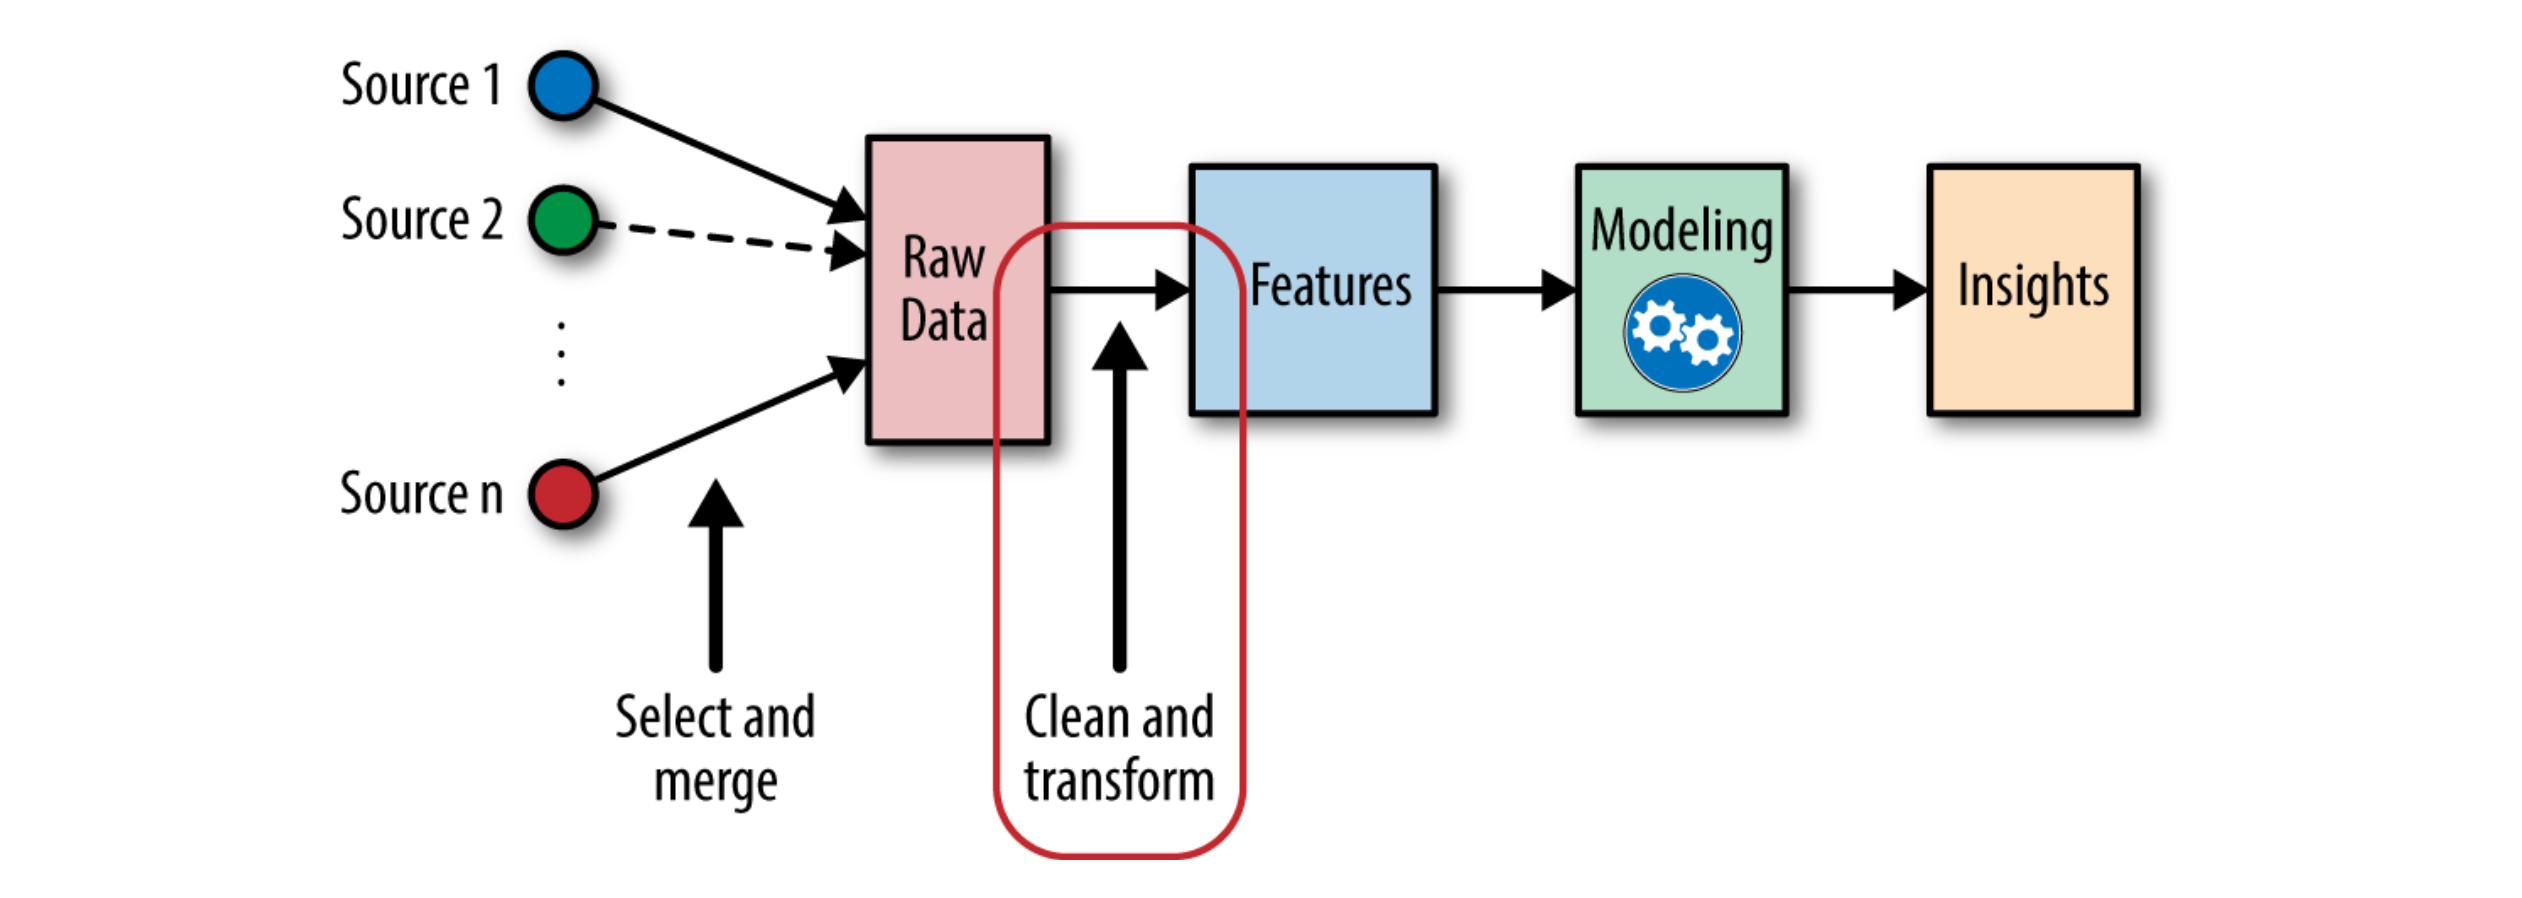
Let's find some missing values in our data! but here is not only in train data, but also in test data too !. So I'll just you `pd.concat` to concatenate both data and I have to store our target `y=train["SalePrice"].value`.

In [ ]:
data = pd.concat((train,test)).reset_index(drop=True)
data.drop("SalePrice", axis=1, inplace=True)
y = train["SalePrice"].values
print("Full data set after merged both dataset together is {}".format(data.shape))

You may ask why the column shape is only 79 ? well, because I just merged two datasets by it row only or vertical stack! and removing one column which is `Id`. Let's calculate the missing values

In [ ]:
data_size = len(data)
all_nan_value = (data.isnull().sum() / data_size) * 100
all_nan_data = all_nan_value.drop(all_nan_value[all_nan_value == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing data': all_nan_data})

missing_data.head(20)

At this point I want to give some insight for what is categorical data and numerical data 
+ Categorical data is a type of data that can be stored in group or categories. It comes what the names or labels, this data is made from the characteristic of the data. We can also call it as quality data.
+ Numerical data is a type of data that can be stored in a number rather than natural language description. Similiar to its name, this data can be collected from only the number. We can also call it as quantity data.

In [ ]:
categorical_feature = data.select_dtypes(include=['object']).columns
categorical_feature

In [ ]:
numerical_feature = data.select_dtypes(exclude=['object']).columns
numerical_feature

### Correlation Matrix
Definition: Let $X$ and $Y$ be two random variables. The correlation coefficient is
\begin{equation} \rho = \frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}} \end{equation}
Which was adapted from the cosine formula, hence we have $-1 \leq{\rho} \leq 1 $. The correlation matrix can tell us which feature is correlated to each other, so we can easily to do the transformations, scaling the important feature. The $Cov(X,Y)$ is the covariance matrix, if we have $X$ and $Y$ be two random variables, then 
\begin{equation} Cov(X,Y) = E[XY] - E[X]E[Y] \end{equation}
If we have a dataset containing $(x_{n}, y_{i})_{n=1}^{N}$, then we have the correlation coefficient can be approximated by 
\begin{equation} \rho = \frac{\frac{1}{N}\sum_{n=1}^{N}x_{n}y_{n}-\bar{x}\bar{y}}{\sqrt{\frac{1}{N}\sum_{n=1}^{N}(x_{n}-\bar{x})^{2}}\sqrt{\frac{1}{N}\sum_{n=1}^{N}(y_{n}-\bar{y})^{2}}} \end{equation}
which $\bar{x}=\frac{1}{N}\sum_{n=1}^{N}x_{n}, \bar{y}=\frac{1}{N}\sum_{n=1}^{N}y_{n}$ are the mean. <br>
Here are the some example of correlation effect.
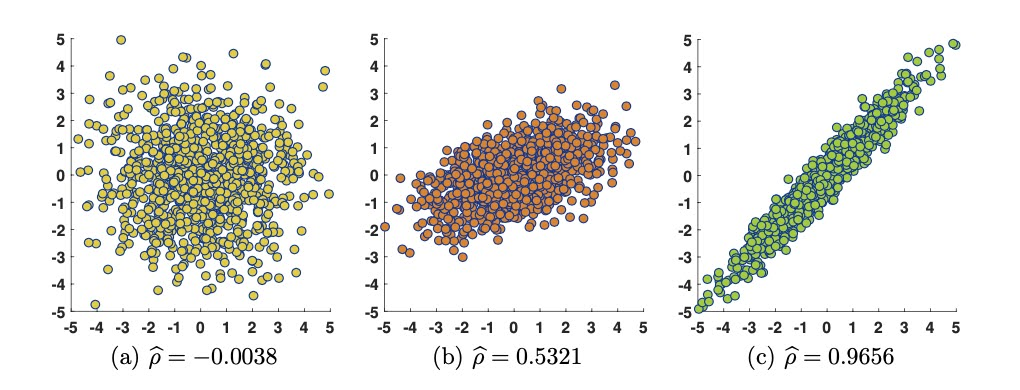

In [ ]:
corr_mat = train.corr()
fig = plt.subplots(figsize=(10,8))
sns.heatmap(corr_mat, vmax=0.99,square=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_nan_data.index, y=all_nan_data, palette=Spectral6)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Percent of missing values', fontsize=16)
plt.title('Percent missing data by feature', fontsize=16)
plt.show()

## Cleaning missing data
We can clean missing data but trying to put the sutiable that could make sence to our categorical feature. By plottung the correlation matrix, it can tell us what feature is really matter the most to our target. By doing this we can easily fill the missing value. Again, before we going to fill all the missing value please be sure that you understand all the meaning of feature as i mentioned above.

For PoolQC or Pool Quality, we gonna fill it as `NA` means no Pool.

In [ ]:
data["PoolQC"] = data["PoolQC"].fillna("NA")

For MiscFeature or Miscellaneous feature not covered in other categories, we gonna fill it as `NA` means None.

In [ ]:
data["MiscFeature"] = data["MiscFeature"].fillna("NA")

For Alley represent type of alley access to property, we gonna fill it as `NA` means no Alley.

In [ ]:
data["Alley"] = data["Alley"].fillna("NA")

For Fence represent Fence quality, we gonna fill it as `NA` means no Fence.

In [ ]:
data["Fence"] = data["Fence"].fillna("NA")

For FireplaceQu: Fireplace quality, we gonna fill it as `NA` means no Fireplace.

In [ ]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("NA")

For LotFrontage: Linear feet of street connected to property, we gonna fill it as the `median` of the neighborhood. As we know that each house will be next to each other so they shall have the similiar LotFrontage.

In [ ]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda value: value.fillna(value.mean()))

For GarageFinish: interior finish of the garage, GarageQual: Garage quality, GarageCond: Garage condition, GarageType: Garage location, so we gonna fill them all as `NA` means no garage.

In [ ]:
features = ["GarageFinish", "GarageQual", "GarageCond", "GarageType"]
for feature in features:
    data[feature] = data[feature].fillna("NA")

For GarageYrBlt: year garage was built, we gonna fill it as `0`

In [ ]:
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0)

For BsmtExposure: Refers to walkout or garden level walls, BsmtCond: Evaluates the general condition of the basement, BsmtQual:  Evaluates the height of the basement, BsmtFinType1: Rating of basement finished area, BsmtFinType2: Rating of basement finished area (if multiple types), we gonna fill them as `NA` means, no Basement.

In [ ]:
features = ["BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinType2"]
for feature in features:
    data[feature] = data[feature].fillna("NA")

For MasVnrType: Masonry veneer type, we gonna fill it as `NA` means None.

In [ ]:
data["MasVnrType"] = data["MasVnrType"].fillna("NA")

For MasVnrArea: Masonry veneer area in square feet, we gonna fill it as `0`.

In [ ]:
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

For MSZoning: Identifies the general zoning classification of the sale. we gonna fill it by follow the most value that exists in our MSZoning.

In [ ]:
count = data["MSZoning"].value_counts()
count

For the most counting value is `RL` means Residential Low Density, so we gonna fit in our feature.

In [ ]:
data["MSZoning"] = data["MSZoning"].fillna(data["MSZoning"].mode()[0])

For BsmtFullBath: Basement full bathrooms, BsmtHalfBath: Basement half bathrooms, we gonna fill it as `0`.

In [ ]:
features = ["BsmtFullBath", "BsmtHalfBath"]
for feature in features:
    data[feature] = data[feature].fillna(0)

For Functional: Home functionality (Assume typical unless deductions are warranted), we gonna fill it as `Typ` means Typical Functionality. So in order predict the price of the house in the future, we shall assume that it is still maintain.

In [ ]:
data["Functional"] = data["Functional"].fillna("Typ")

For GarageCars: Size of garage in car capacity, GarageArea: Size of garage in square feet, we gonna fill them as 0. means no Garage.

In [ ]:
features = ["GarageCars", "GarageArea"]
for feature in features:
    data[feature] = data[feature].fillna(0)

For Electrical: Electrical system, we gonna fill it as the commonly use type of circuit in the house is SBrkr: Standard Circuit Breakers & Romex.

In [ ]:
mode = data["Electrical"].mode()
mode

In [ ]:
data["Electrical"] = data["Electrical"].fillna(data["Electrical"].mode())

For KitchenQual: Kitchen quality, we gonna fill it as `TA`: Typical/Average which is the most frequent one.

In [ ]:
count = data["KitchenQual"].value_counts()
count

In [ ]:
data["KitchenQual"] = data["KitchenQual"].fillna("TA")

For TotalBsmtSF: Total square feet of basement area, we gonna fill it as 0.

In [ ]:
data["TotalBsmtSF"] = data["TotalBsmtSF"].fillna(0)

For BsmtFinSF1: Type 1 finished square feet, BsmtFinSF2: Type 2 finished square feet, BsmtUnfSF: Unfinished square feet of basement area, we gonna fill them as 0.

In [ ]:
features = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]
for featue in features:
    data[feature] = data[feature].fillna(0)

In [ ]:
data_size = len(data)
all_nan_value = (data.isnull().sum() / data_size) * 100
all_nan_data = all_nan_value.drop(all_nan_value[all_nan_value == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing data': all_nan_data})

missing_data.head(20)

So our missing value is much better now after we try to clean all missing values.

Let's transform some numerical feature that should be categorical feature

In [ ]:
data["MSSubClass"] = data["MSSubClass"].apply(str)

features = ["OverallCond", "YrSold", "MoSold"]
for feature in features:
    data[feature] = data[feature].astype(str)

### LabelEncoder
This function will convert the target label as number between 0 and 1 and yes if you as what it is like thatm because we don't fit string in our data here, everything must be a matrix which contain number.

In [ ]:
features = ["FireplaceQu", "BsmtQual", "BsmtCond", "GarageQual", "GarageCond", "ExterQual",
            "ExterCond", "HeatingQC", "PoolQC", "KitchenQual", "BsmtFinType1", "BsmtFinType2",
            "Functional", "Fence", "BsmtExposure", "GarageFinish", "LandSlope","LotShape",
            "PavedDrive", "Street", "Alley", "CentralAir", "MSSubClass", "OverallCond", 
            "YrSold", "MoSold", "MSZoning"]
for feature in features:
    labelencoder = LabelEncoder()
    labelencoder.fit(list(data[feature].values))
    data[feature] = labelencoder.transform(list(data[feature].values))

In [ ]:
print(f"Data shape: {data.shape}")

In [ ]:
data["ToltalSF"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]
data["ToltalSF"].mean()

* ### Skewness
+ $E \left [ \left( \frac{X-\mu}{\sigma}\right)^{3} \right ]$
+ It measures the asymmetry of the distribution
+ Normal distribution have skewness 0
+ Skewed towards left: positive
+ Skewed towards right: negative
+ Symmetric: zero <br>
### Kurtosis
+ $E \left [ \left( \frac{X-\mu}{\sigma}\right)^{4} \right ]$
+ Measures how heavy-tailed the distribution is. Normal distribution has kurtosis 3.
+ Some statisticians prefer excess kurtosis $\kappa − 3$, so that Gaussian has excess kurtosis 0.
+ Kurtosis measures how heavy-tailed the distribution is.
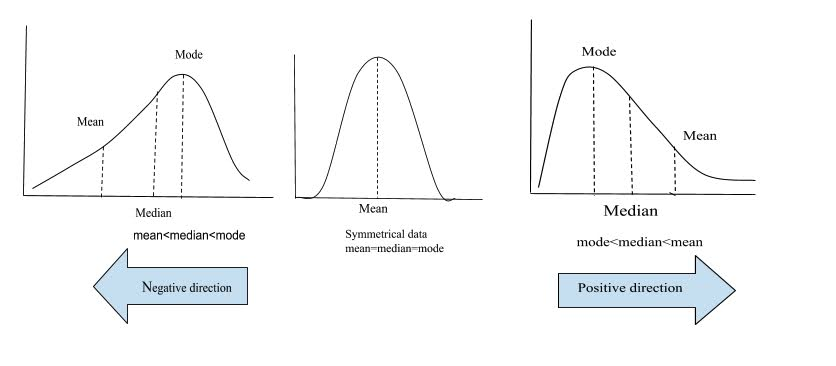

In [ ]:
numerical_feature = list(data.select_dtypes(exclude="object"))

skewness_features = data[numerical_feature].apply(lambda feature: scipy.stats.skew(feature.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skewness_features})
skewness.head(10)

## Boxcox transform
Box-cox transform is just the special cast of the power transforms. The power transformation is defined as continuous functin with respect to the power of paramater $\lambda$. For data vectors $x_{1},x_{2},\cdots,x_{n}$ in which $x_{i}>0$
\begin{equation} 
 x_{i}^{(\lambda)} = \begin{cases} \frac{x_{i}^{\lambda}-1}{\lambda(GM(x))^{\lambda-1}} & \text{ if } \lambda \neq 0 \\
 GM(x)lnx_{i} & \text{ if } \lambda = 0 
 \end{cases} \end{equation}
 where \begin{equation} GM(x) = \left( \prod_{i=1}^{n} x_{i} \right)^{\frac{1}{n}} = \sqrt[n]{x_{1}x_{2}\cdots x_{n}} \end{equation}
 So for our case (Box-cox transform) <br>
 The one-parameter Box–Cox transformations are defined as
 \begin{equation} 
                 x_{i}^{(\lambda)} = \begin{cases} \frac{x_{i}^{\lambda}-1}{\lambda} & \text{ if } \lambda \neq 0 \\
                 lnx_{i} & \text{ if } \lambda = 0 \end{cases} \end{equation}

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewness_features = skewness.index
lam = 0.15
for feat in skewness_features:
    data[feat] = boxcox1p(data[feat], lam)


In [ ]:
fig = plt.figure(figsize=(8, 5))
fig = sns.distplot(data["PoolArea"], fit=scipy.stats.norm, kde=False)
fig = plt.ylabel("Frequency", fontsize=16)
fig = plt.xlabel("PoolArea", fontsize=16)
fig = plt.title("PoolArea distribution", fontsize=16)

Okay, so now it look much better !

In [ ]:
data = pd.get_dummies(data)
data.shape

## Modeling regression Algorithm 
In order to make a good model, we have the split our data into train and test data. The train data is the data that we fit the model to learn, and the test data is the data that we use to test our model after we trained it to see if your model is good.

In [ ]:
n_train = train.shape[0]
train = data[:n_train]
test = data[n_train:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=42)

Learning the parameters of a prediction function and testing it on the same data doesn't make the good model at all, because the model would just keep repeating learning the same parameter on the same data and wouldn't be able to improve it parameters. The solution to this problem, we can randomly split our data into the subset data that would give our model a better random parameter to learn better !.Let's see how the cross validation split our data !.

In [ ]:
X_train

In [ ]:
X_test

Wow, it's different from the original !

### The Bias/Variance Tradeoff
One of the important theoretical result of the Statistic and Machine Learning is the model's generalization error that can be expressed as the sum of three very difference errors:
+ Bias = how far your average is from the truth. A high-bias model is the most likely to underfit the training data.
+ Variance = how much fluctuation you have around the avergae. A model with many degrees of freedom such as high polynomial model is likely to have hight varaince, and this to overfit the training data. <br>
(a). Shows the case with a low bias and a low variance. All predictors are very close to the ground truth, and they have small fluctuation around their average. <br>
(b). Shows the case of a high bias and low variance. It has a high bias because the entire group of the predictor is shifted to the corner. <br>
(c). Shows the case of the a low bias but high variance. In this case, the fluctuation around the average is large. <br>
(d). Shows the case of the high bias and high variance which is the worst senario!.
![]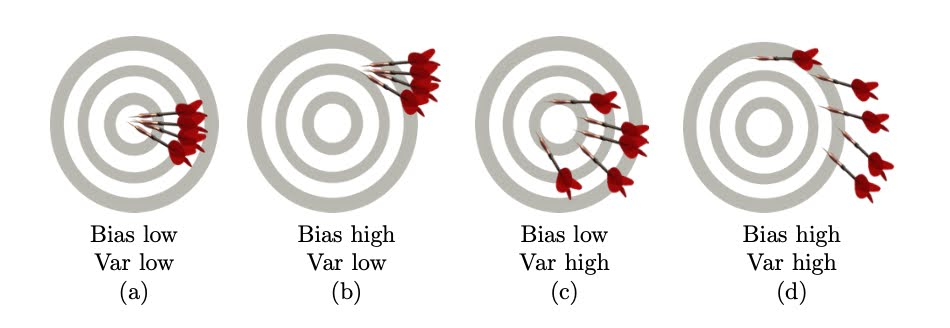

### Ridge regression
Ridge regression or we can call it Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $\alpha\sum_{i=1}^{n}\theta_{i}^{2}$ is added to the cost function which $\alpha$ is the hyperparameter that we can tune in order to make our model fit better!. This algorithms force the learning algorithm to not only fit the data but also keep the model weights as small as possile to prevent the model overfiting!.<br> The Ridge regularization equation is 
\begin{equation} \underset{\theta \in \mathbb{R}^{d}}{minimize} \| X\theta - y\|^{2}+\alpha\| \theta\|^{2} \end{equation}
\begin{equation} \text{Cost Function} \hspace{1.5cm} J(\theta)=\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}+ \frac{1}{2} \alpha \sum_{i=1}^{n}\theta_{i}^{2} \end{equation}
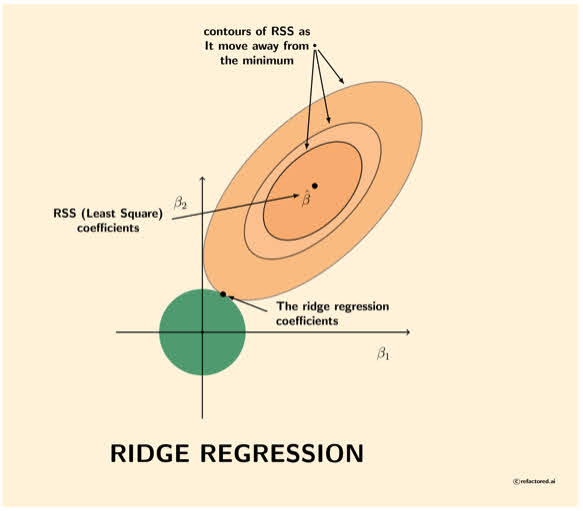

In [ ]:
ridge_reg = Ridge()
model = ridge_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The ridge score: {score}")

### Lasso regression

Lasso regression or Least Absolute Shrinkage and Selection Operator Regression is an another regularized verion of Linear Regression. It look like Ridge regression, it adds a regularization term to the cost function, but it use $l_{1}$ norm of the weight vector instead of half the square of the $l_{2}$ norm.
The Lasso regression equation is \begin{equation} \underset{\theta \in \mathbb{R}^{d}}{minimize} \| X \theta - y\|^{2}+\alpha \| \theta \| \end{equation}
\begin{equation} \text{ Cost Function} \hspace{1.5cm} J(\theta)=\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}+\alpha \sum_{i=1}^{n}|\theta_{i} |\end{equation}
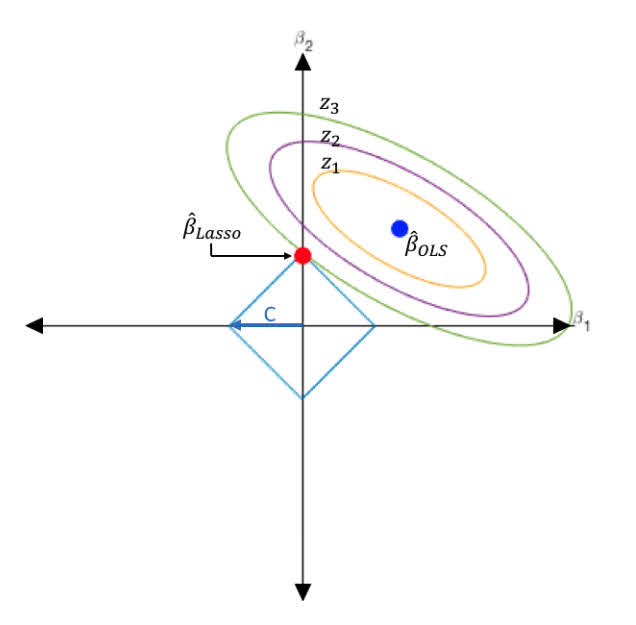

In [ ]:
lasso_reg = Lasso()
model = lasso_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The lasso score: {score}")

### ElasticNet regression
ElasticNet is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso's regularization terms. $r$ is the mixed ratio. The regressioin is the most always preferable to have at least a bit of regularization.
\begin{equation} J(\theta)=\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2} + \alpha \sum_{i=1}^{n} |\theta_{i}| + \frac{1-r}{2}\alpha \sum_{i=1}^{n}\theta_{i}^{2} \end{equation}

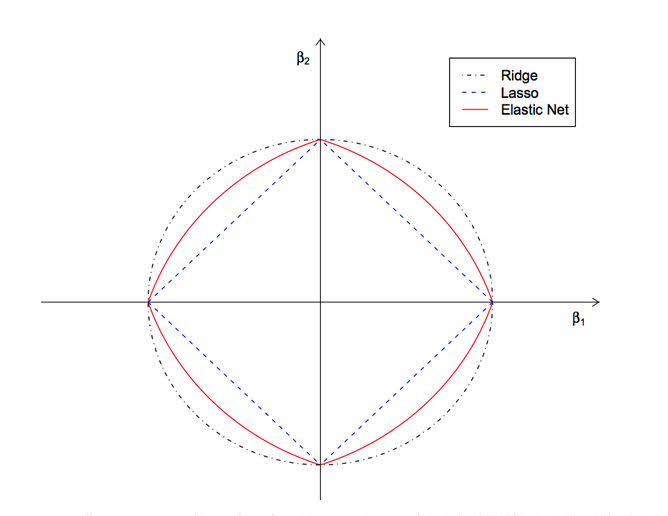
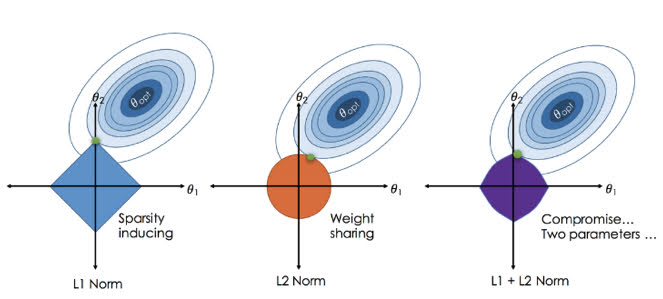

In [ ]:
elastic_reg = ElasticNet()
model = elastic_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The lasso score: {score}")

### RandomForest regression
RandomForest is an ensemble of Decision Trees. The Random Forest algorithm introduces extra randomness when growing trees instead of searching for very best feature when splitting a node, it searches for the best feature among a random forest subset of features. This result in a greater tree diversity, which trades a higher bias for a lower variance.

In [ ]:
random_forest_reg = RandomForestRegressor()
model = random_forest_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The RandomForest score: {score}")

### Gradient Boosting Regression
Gradient Boosting Regression is one of the very popular boosting algorithm. Gradient Boosting Regression works sequentialy addings all predictors to an ensemble which each one correcting its predessor and instead of tweaking the instance weights at every iteration, it tries to fut the new predictor to the residual errors that could be made by the previous predictor.

In [ ]:
gradient_boosting_reg = GradientBoostingRegressor()
model = gradient_boosting_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The Gradient Boosting score: {score}")

### AdaBoost Regression
AdaBoost Regression is the also an ensemble algorithms. This algorithms tries to make a new predictor which correct its predessor to pay more attention to the training instance that could underfitted. AdaBoost adds predictors to the ensemble which is gradually making a better learning.

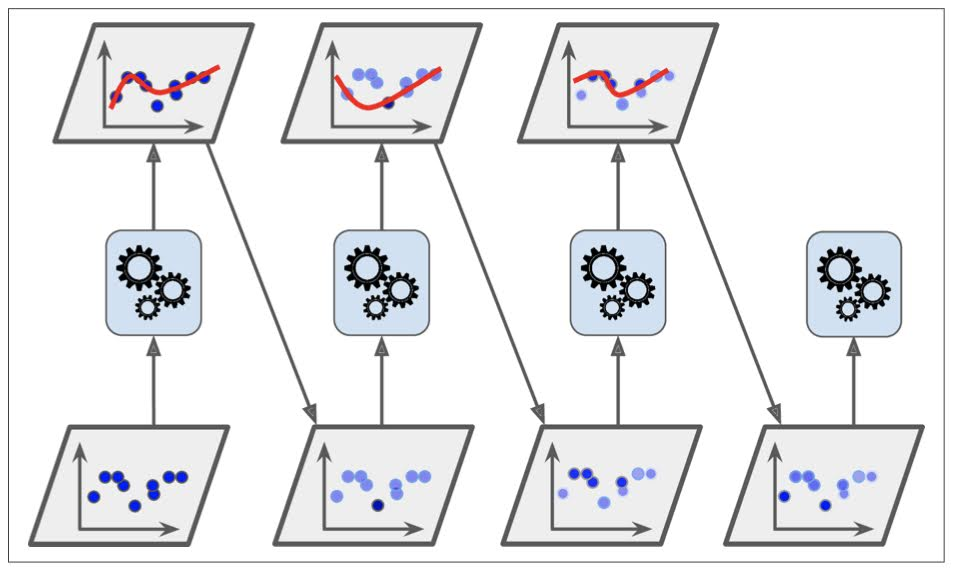

In [ ]:
ada_boost_reg = AdaBoostRegressor()
model = ada_boost_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The AdaBoost score: {score}")

### XGBoost
XGBoost is a decision-tree based ensemble Machine Learning algorithms that use Gradient Boosting framework. XGBoost can approaches the process of the sequetial tree building as a parallelizing implementation, it has Tree Pruning that can stopping criterion for tree splitting with GBM framework is greedu in nature and depends on the negative loss criterion at the point of split. XGBoost is also a hardware optimization that have been designed to make efficient use of hardware resources.

In [ ]:
xgb_reg = xgb.XGBRegressor()
model = xgb_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The XGBscore: {score}")

### Light GBM 
Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks. It splits theb tree leaf wise with the best fit whereas other boosting algorithm split the tree depth wise or level wise rather than leaf-wise. The advantage of using Light GBM is that Faster training speed and higher efficiency, it uses histogram based algorithm, it encapsulate continuous feature values into discrete bins, Lower memory and gives a better accuracy than any other boosting algorithm.

In [ ]:
lgb_reg = lgb.LGBMRegressor()
model = lgb_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The LGBMscore: {score}")

### Voting Regressor
Voting Regressor is an ensemble algorithm that can group all the predictor in purpose of making a better learning. Rather than learning alone as one predictor or randomly guessing, Voting classifier groups all the predictors as one as a strong learner.
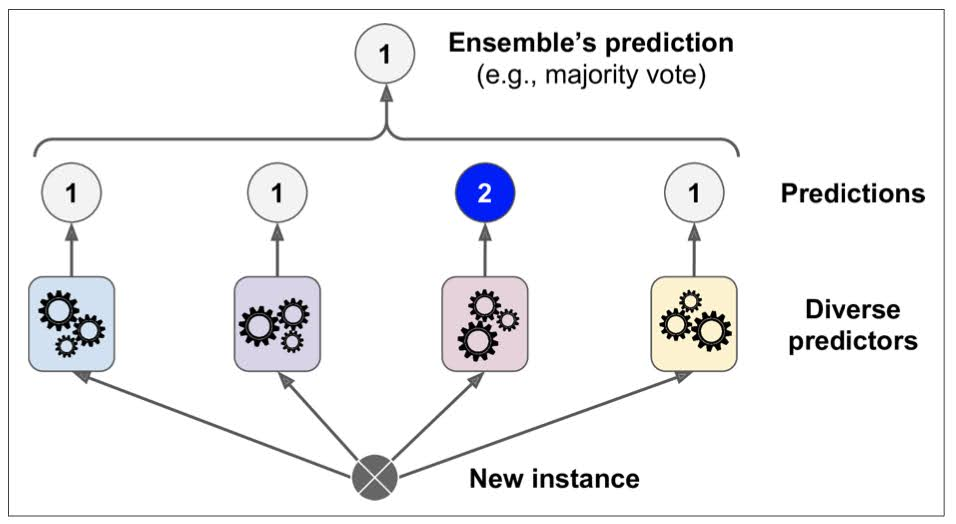

In [ ]:
votting_reg = VotingRegressor([
    ('Ridge', Ridge()),
    ('RandomForest', RandomForestRegressor()),
    ('Gradient Boostng', GradientBoostingRegressor()),
    ('AdaBoost', AdaBoostRegressor()),
    ('XGBoost', xgb.XGBRegressor()),
    ('LGBMBoost', lgb.LGBMRegressor())
])
model = votting_reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The Voting score: {score}")

Please upvote my notebook if you like it ;)